In [1]:
%reset -f

import numpy as np
np.set_printoptions(linewidth=210)  # 210
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))   # 100%

import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [2]:
# General parameters:
ratio_rho   = 1.0e+4        # Ratio between central density and mean density of the Universe.
aH          = 0.25   #0.01           # Constant in Herquist potential
n_points_1D = 64
n_points    = n_points_1D**3

km2mpc   = 1.0/3.08568025e19
kg2msun  = 1.0/(1.9198e+30)
m2mpc    = 1.0/(3.08568025e22)
m2kpc    = 1.0/(3.08568025e19)
sec2gyr  = 1.0 / (1.0e+9 * 365.25 * 23.56 * 3600)
G_mks    = 6.67428e-11   # m^3 kg^-1 s^-2
omegam   = 0.3
h_small  = 1.0
H0       = 100.0*h_small*km2mpc          # km/sec/Mpc
rho_crit = (3.0*H0**2)/(8.0*np.pi*G_mks*m2mpc**3/kg2msun)
rho_mean = omegam*rho_crit

#r_min = 1.0e-5   #1.0e-2  # minimum distance from the center for generating particles
#r_max = np.sqrt(3.0)*box/2.0

def M_hernquist(r):
    
    # Mass profile without taking into account background:
    # In units of whatever we have in rho_mean
    return 4.0*np.pi*(ratio_rho*rho_mean)*aH**3*(r/aH)**2/(1.0+r/aH)**2/2.0
    #return (r/aH)**2/(1.0+r/aH)**2/2.0
    #return 4.0*np.pi*(ratio_rho)*aH**3*(r/aH)**2/(1.0+r/aH)**2/2.0

# Density:
def rho_hernquist(r):
    
    return ratio_rho*rho_mean/((r/aH)*(1.0+r/aH)**3) #+ rho_background
    #return ratio_rho/((r/aH)*(1.0+r/aH)**3) #+ rho_background
    
    
# Define box size given the parameters of the profile:
M_total = M_hernquist(10000)
#mp = M_total/n_points

# This gives the box size that is needed for the mean density of Hernquist to be the mean density of the Universe:
# If you use this, then you do not need to add an additional background component.
# This background component may be important in the case of MOND because it may bring things back to the Newtonian limit (maybe).
if False:
    box         = (M_total/rho_mean)**(1.0/3.0)
    box_over_two = box/2.0
    print("box = ", box)
else:
    # This is a different box size which may require a backgroun.
    box = 20.0
    
box_over_two = box/2.0

if True:
    
    correction_rho = (rho_mean*box**3-M_total)/(box**3)
    print("correction_rho = ", correction_rho)
    if correction_rho<0:
        correction_rho = 0

    print("rho_crit       = %e" % rho_crit, "Msun/mpc^3")
    print("rho_mean       = %e" % rho_mean, "Msun/mpc^3")
    print("M total        = %e" % M_total, "Msun")
    print("rho_mean*box   = %e" % (rho_mean*box**3), "Msun")
    print("rho_background = %e" % correction_rho)
    
    mp = rho_mean*box**3/n_points
    print(M_total/mp)
    print((rho_mean*box**3-M_total)/mp)
    n_parts_hernquist = int(M_total/mp)
    n_parts_back      = n_points - n_parts_hernquist
    

correction_rho =  75654573588.62263
rho_crit       = 2.874563e+11 Msun/mpc^3
rho_mean       = 8.623690e+10 Msun/mpc^3
M total        = 8.465865e+13 Msun
rho_mean*box   = 6.898952e+14 Msun
rho_background = 7.565457e+10
32168.30033763741
229975.6996623626


In [3]:
from scipy.interpolate import interp1d

# Invert M(r)
r_table = np.logspace(-30,+30, 1000)
#M_table = np.divide(M_hernquist(r_table),r_table**3)  # I do not know why people divide by r^3...
M_table = M_hernquist(r_table)
func = interp1d(M_table, r_table)

In [4]:
np.random.seed(1)

x_data = np.zeros(n_points)
y_data = np.zeros(n_points)
z_data = np.zeros(n_points)

# Set background
x_data[0:n_parts_back] = np.random.uniform(low=0, high=box, size=n_parts_back)
y_data[0:n_parts_back] = np.random.uniform(low=0, high=box, size=n_parts_back)
z_data[0:n_parts_back] = np.random.uniform(low=0, high=box, size=n_parts_back)

print(x_data[n_parts_back-1], x_data[n_parts_back])
n = n_parts_back
while True:
    
    # Draw radius from the mass:
    M = np.random.uniform(low=0, high=M_total, size=1)
    r = func(M)
        
    # Draw the angles:
    cos_theta  = 1.0-2.0*np.random.uniform(low=0, high=1.0, size=1)
    phi   = np.random.uniform(low=0, high=2.0*np.pi, size=1)

    x_data[n] = r*np.sqrt(1.0-cos_theta**2)*np.cos(phi) + box_over_two
    y_data[n] = r*np.sqrt(1.0-cos_theta**2)*np.sin(phi) + box_over_two
    z_data[n] = r*cos_theta                             + box_over_two
    
    # Check that particle is inside the box
    if x_data[n]>0 and x_data[n]<box and y_data[n]>0 and y_data[n]<box and z_data[n]>0 and z_data[n]<box:   #and r_trial<box/2.0:
        n = n + 1
        if(np.mod(n,10000)==0):
            print(n)
    
    if n==n_points:
        break
        
# Store solution:
# It may be necessary to add $a$ factors to compare this solution with Ramses.
# (Ramses fields contain $a$ factors in their definitions)
if False:
    np.savetxt("hernquist_particles_%dparts_%dmpc.dat" % (n_points_1D, int(box)), \
               np.column_stack([x_data*h_small, y_data*h_small, z_data*h_small, np.zeros(n_points), np.zeros(n_points), np.zeros(n_points)]))
else:
    # Raw binary for Solve:
    file = "hernquist_particles_%dparts_%dmpc.dat" % (n_points_1D, int(box))
    f = open(file,'wb')
    tmp = np.column_stack([x_data, y_data, z_data, np.zeros(n_points), np.zeros(n_points), np.zeros(n_points)])
    np.array(tmp, dtype=np.float64).tofile(f)
    f.close()
    print("Particles stored in ", file)

print("Done")

19.066977820927967 0.0
230000
240000
250000
260000
Particles stored in  hernquist_particles_64parts_20mpc.dat
Done


mp =  2631741482.241626


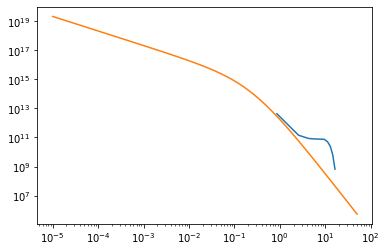

In [5]:
import scipy as sp
import scipy.stats

# These histograms are not correct:
mp = box**3*rho_mean/n_points
r_min = 1.0e-5
r_max = 50.0
print("mp = ", mp)
r_plot   = np.logspace(np.log10(r_min),np.log10(r_max), 100)
rho_plot = [ rho_hernquist(r_plot[i]) for i in range(len(r_plot)) ]

radius = np.sqrt((x_data-box_over_two)**2+(y_data-box_over_two)**2+(z_data-box_over_two)**2)
#hist = np.histogram(radius, defaultlimits=None, weights=None, printextras=False)   #[source]¶
hist = np.histogram(radius) #, range=(1.0,100.0)) #, density=True)
centers = (hist[1][1:] + hist[1][:-1])/2
dx = centers[1]-centers[0]

plt.plot(centers, hist[0]/(4.0*np.pi*centers**2*dx)*mp)
plt.plot(r_plot, rho_plot)
plt.yscale('log')
plt.xscale('log')

262144 63.999999999999986 262144


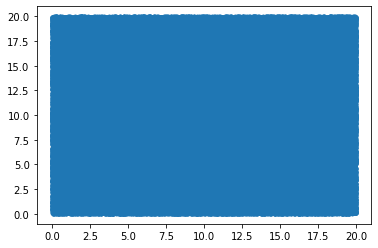

In [6]:
print(len(x_data), len(x_data)**(1.0/3), 64**3)
plt.scatter(x_data, z_data, marker=".")
plt.show()

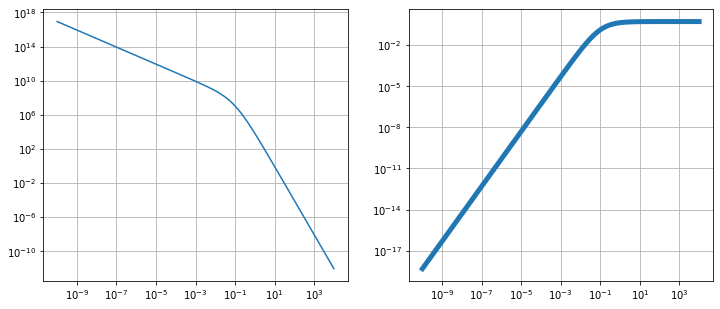

In [170]:

r_plot = np.logspace(np.log10(1.0e-10),np.log10(1.0e+4), 100)
M_plot = np.logspace(-10, 15.5, 100)

plt.figure(figsize=(12,5))

plt.subplot(121)
rho_plot = [ rho_hernquist(r_plot[i]) for i in range(len(r_plot)) ]
plt.plot(r_plot, rho_plot)
plt.xscale('log')
plt.yscale('log')
plt.grid()

plt.subplot(122)
plt.plot(r_plot, M_hernquist(r_plot), lw=5)
#plt.plot(func(M_plot), M_plot, lw=3)
plt.xscale('log')
plt.yscale('log')
plt.grid()


plt.show()